In [1]:
project_name = 'face-exp-resnet'

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
from PIL import Image
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
import torchvision.models as models
from torch.utils.data import DataLoader, RandomSampler
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import torchvision.models as models
import zipfile
from sklearn.model_selection import train_test_split
import shutil
%matplotlib inline

In [4]:
zip_file_path = '/content/drive/MyDrive/Dataset_new.zip'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('/content/Dataset_new')

data_dir = '/content/Dataset_new/Dataset_new'
print(os.listdir(data_dir))
classes = os.listdir(data_dir)
print(classes)


# Creating directories for train, validation, and test splits
for split in ['train', 'val', 'test']:
    for cls in classes:
        os.makedirs(f'data/{split}/{cls}', exist_ok=True)

# Splitting and copying files
for cls in classes:
    images = os.listdir(os.path.join(data_dir, cls))
    train_files, temp_files = train_test_split(images, test_size=0.4, random_state=42)
    val_files, test_files = train_test_split(temp_files, test_size=0.5, random_state=42)

    # Copying files to respective directories
    for file_list, split in zip([train_files, val_files, test_files], ['train', 'val', 'test']):
        for img in file_list:
            shutil.copy(os.path.join(data_dir, cls, img), f'data/{split}/{cls}/{img}')

print("Data split completed!")
data_dir='data'


['pain', 'anger', 'disgust', 'sad', 'fear', 'happy']
['pain', 'anger', 'disgust', 'sad', 'fear', 'happy']
Data split completed!


In [5]:
print('Train set')
for clas in classes:
  if clas != ".DS_Store":

    print(len(os.listdir(data_dir+'/train/'+clas)), clas)


Train set
100 pain
128 anger
120 disgust
134 sad
97 fear
138 happy


In [6]:
train_tfms = tt.Compose([
    tt.RandomResizedCrop(224, scale=(0.6, 1.0)),
    tt.RandomHorizontalFlip(),
    tt.RandomRotation(40),
    tt.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.3),
    tt.RandomAffine(degrees=0, translate=(0.2, 0.2), scale=(0.8, 1.2)),
    tt.ToTensor(),
    tt.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

valid_tfms = tt.Compose([
    tt.Resize((224, 224)),
    tt.ToTensor(),
    tt.Normalize(mean=[0.485,0.456, 0.406],std=[0.229, 0.224, 0.225])
    ])

In [8]:
train_ds = ImageFolder(data_dir+'/train', train_tfms)
valid_ds = ImageFolder(data_dir+'/val', valid_tfms)
print(train_ds.class_to_idx)



print('train set')
for clas in classes:
  if clas != ".DS_Store":

    print(len(train_ds), clas)

{'anger': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'pain': 4, 'sad': 5}
train set
715 pain
715 anger
715 disgust
715 sad
715 fear
715 happy


In [8]:
batch_size = 64

In [9]:
train_dl = DataLoader(
    train_ds,
    batch_size,
    sampler=RandomSampler(train_ds, replacement=True, num_samples=len(train_ds) * 3)
                     )

valid_dl = DataLoader(
    valid_ds,
    batch_size*2,
    num_workers=4,
    pin_memory=True
                     )

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [10]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(16, 12))
        ax.set_xticks([])
        ax.set_yticks([])

        # Normalize pixel values to [0, 1] range for correct display
        grid_img = make_grid(images[:64], nrow=16).permute(1, 2, 0).numpy()
        grid_img = (grid_img - grid_img.min()) / (grid_img.max() - grid_img.min())

        ax.imshow(grid_img)  # Display RGB image
        plt.show()
        break

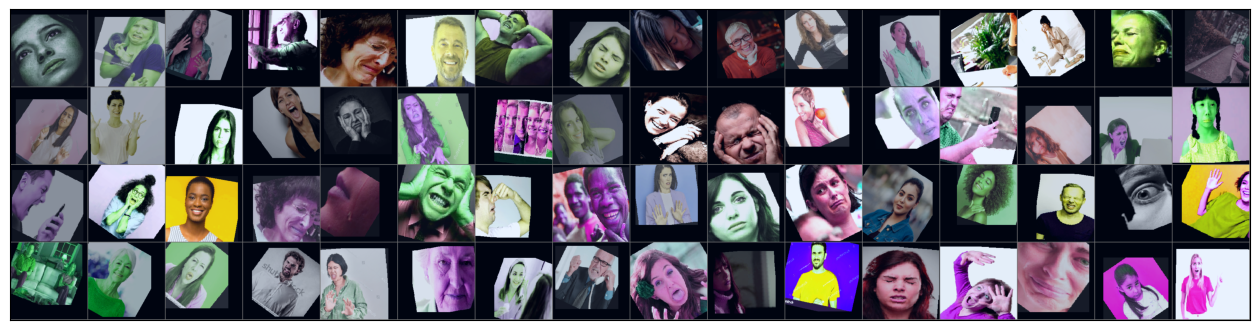

In [11]:
show_batch(train_dl)

In [12]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [13]:
device = get_default_device()
device

device(type='cuda')

In [14]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)



In [15]:
class ResNet50(nn.Module):
    def __init__(self, num_classes):
        super(ResNet50, self).__init__()

        # Load the ResNet-50 model with pretrained weights
        self.network = models.resnet50(pretrained=True)

        # Add Dropout layer before the final fully connected layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(num_ftrs, num_classes)
        )

    def forward(self, x):
        return self.network(x)

In [16]:
model = ResNet50(6)
model = to_device(model, device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 164MB/s]


In [17]:
from tqdm.notebook import tqdm
import torch.optim as optim

In [18]:


# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.99, weight_decay=0.0004)
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0005)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.3, patience=3, verbose=True)


# Training loop
num_epochs = 30
best_val_loss = float('inf')

for epoch in range(num_epochs):
    # Train phase
    model.train()
    running_loss = 0.0
    for images, labels in train_dl:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Validation phase
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in valid_dl:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Print epoch results
    train_loss = running_loss / len(train_dl)
    val_loss /= len(valid_dl)
    accuracy = 100 * correct / total
    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {train_loss:.4f}, '
          f'Val Loss: {val_loss:.4f}, '
          f'Accuracy: {accuracy:.2f}%')

    scheduler.step(val_loss)



/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/30], Train Loss: 1.4214, Val Loss: 1.1571, Accuracy: 59.34%
Epoch [2/30], Train Loss: 0.7819, Val Loss: 1.0035, Accuracy: 66.39%
Epoch [3/30], Train Loss: 0.4787, Val Loss: 0.8672, Accuracy: 68.05%
Epoch [4/30], Train Loss: 0.3266, Val Loss: 1.0803, Accuracy: 67.22%
Epoch [5/30], Train Loss: 0.2423, Val Loss: 0.9133, Accuracy: 70.54%
Epoch [6/30], Train Loss: 0.1762, Val Loss: 1.0935, Accuracy: 66.80%
Epoch [7/30], Train Loss: 0.1604, Val Loss: 0.9500, Accuracy: 68.88%
Epoch [8/30], Train Loss: 0.1087, Val Loss: 0.9743, Accuracy: 73.03%
Epoch [9/30], Train Loss: 0.0706, Val Loss: 0.9507, Accuracy: 72.20%
Epoch [10/30], Train Loss: 0.0686, Val Loss: 1.0380, Accuracy: 71.37%
Epoch [11/30], Train Loss: 0.0513, Val Loss: 0.9846, Accuracy: 71.78%
Epoch [12/30], Train Loss: 0.0514, Val Loss: 1.0234, Accuracy: 71.37%
Epoch [13/30], Train Loss: 0.0502, Val Loss: 0.9796, Accuracy: 73.03%
Epoch [14/30], Train Loss: 0.0456, Val Loss: 0.9387, Accuracy: 74.27%
Epoch [15/30], Train Loss: 0.

In [19]:
test_ds = ImageFolder(data_dir + '/test', valid_tfms)
test_dl = DataLoader(test_ds, batch_size*2, num_workers=4, pin_memory=True)

# Function to calculate accuracy
def evaluate_accuracy(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

# Run on test set after training
test_accuracy = evaluate_accuracy(model, test_dl)
print(f"Test Accuracy: {test_accuracy:.2f}%")


Test Accuracy: 74.69%


In [20]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt


def evaluate_with_confusion_matrix(model, dataloader):
    model.eval()
    all_preds, all_labels = [], []
    target_classes=[]

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    acc = accuracy_score(all_labels, all_preds)
    for clas in classes:
      if clas != ".DS_Store":
         target_classes.append(clas)

    per_class_accuracy = cm.diagonal() / cm.sum(axis=1)
    for idx, class_name in enumerate(target_classes):
        print(f"Accuracy for {class_name}: {per_class_accuracy[idx] * 100:.2f}%")


    return acc

# Evaluate on the test set
accuracy = evaluate_with_confusion_matrix(model, test_dl)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Accuracy for happy: 67.44%
Accuracy for pain: 87.50%
Accuracy for sad: 93.94%
Accuracy for disgust: 76.09%
Accuracy for fear: 73.53%
Accuracy for anger: 55.56%


In [21]:
torch.save(model.state_dict(), 'model_weights.pth')

# Optionally, save the full model (including architecture)
torch.save(model, 'model_full.pth')